In [1]:
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_recall_fscore_support,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_regression
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.svm import SVC, LinearSVC
from keras.utils import to_categorical
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV
import networkx as nx
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import itertools

In [2]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [3]:
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

In [4]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [5]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

In [6]:
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Seasonal Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Seasonal Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    # df['Seasonal Point Difference'] = df['Home Total Seasonal Points'] - df['Away Total Seasonal Points']
    # df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [7]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date',
    'Season'
]

updated_df = df[features].copy()
updated_df.dropna(inplace=True)

In [8]:
numerical_features = [
    # Home Advantage,
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    ]

In [9]:
def standardisation(df, terms=numerical_features):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=numerical_features):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Explained Variance Ratio:  [3.16576232e-01 8.45400333e-02 5.77480471e-02 4.98413595e-02
 3.97925540e-02 3.75659122e-02 3.41837323e-02 3.31313049e-02
 2.44209614e-02 2.42266364e-02 2.10247585e-02 1.90175701e-02
 1.81513320e-02 1.75881751e-02 1.65469751e-02 1.53220145e-02
 1.47904115e-02 1.39839348e-02 1.30258432e-02 1.25829526e-02
 1.18487923e-02 1.10295738e-02 1.02416566e-02 9.20479283e-03
 8.43066550e-03 7.85997645e-03 7.05260791e-03 6.22120658e-03
 5.48273633e-03 4.98185979e-03 4.62467530e-03 4.33793785e-03
 4.22584095e-03 4.05631205e-03 3.62936796e-03 3.54816995e-03
 3.00574141e-03 2.89590597e-03 2.75576708e-03 2.51615232e-03
 2.50223162e-03 2.20056031e-03 2.13312656e-03 1.82915504e-03
 1.59959876e-03 1.57101208e-03 1.52742630e-03 1.23717945e-03
 1.17426109e-03 1.06742370e-03 7.73061379e-04 2.30962891e-04
 1.20645223e-04 1.70988808e-05 2.93059148e-06 2.73610511e-06
 1.10141878e-07 4.34644920e-18]
Number of components to retain 95% variance: 31


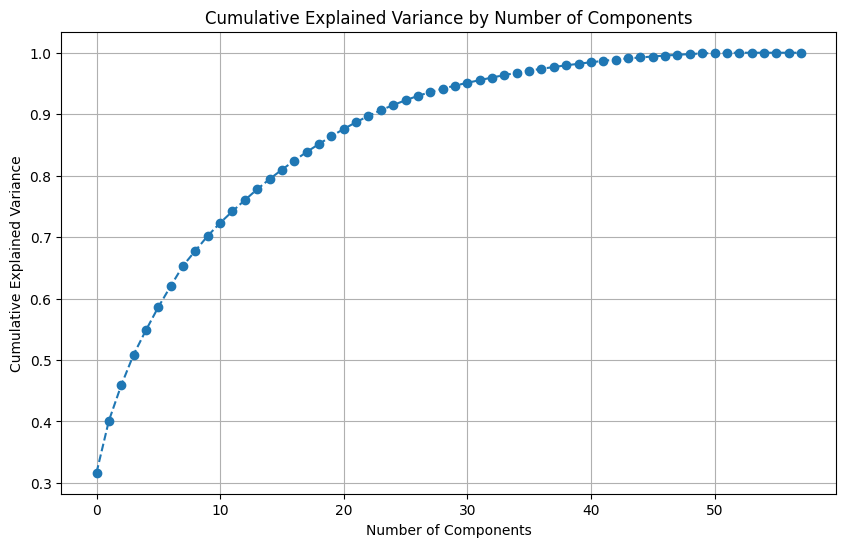

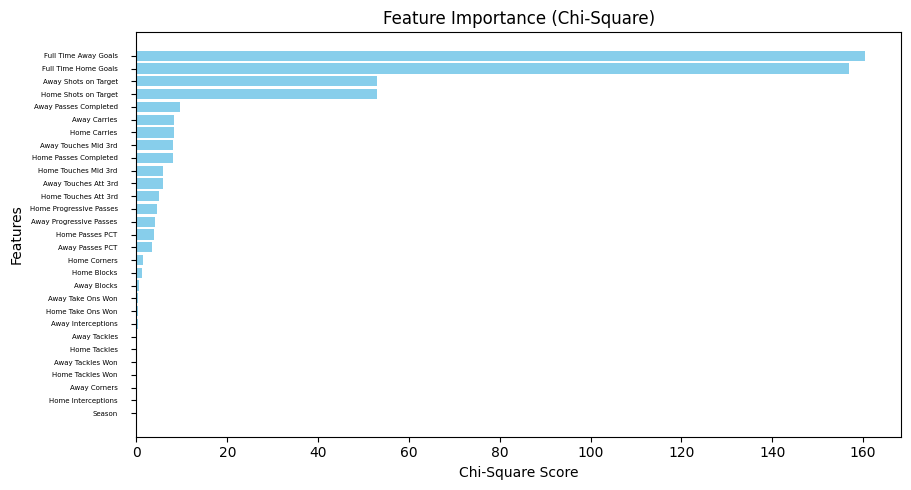

In [10]:
def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)



def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(updated_df)   

In [11]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df

updated_df = create_strength_features_separate(updated_df, chi2_df)


In [17]:
# Remove these 4 features
updated_df['Home Goals Scored'] = updated_df['Full Time Home Goals']
updated_df['Home Goals Conceded'] = updated_df['Full Time Away Goals']
updated_df['Away Goals Scored'] = updated_df['Full Time Away Goals']
updated_df['Away Goals Conceded'] = updated_df['Full Time Home Goals']
updated_df["Home Performance"] = updated_df["Match Outcome"].apply(lambda x: 3 if x == 1 else 1 if x == 0 else 0)
updated_df["Away Performance"] = updated_df["Match Outcome"].apply(lambda x: 3 if x == -1 else 1 if x == 0 else 0)

updated_df['Home Avg Attacking Strength'] = updated_df.groupby('Home Team')['Home Attack Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Avg Defense Strength'] = updated_df.groupby('Home Team')['Home Defense Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Attacking Strength'] = updated_df.groupby('Away Team')['Away Attack Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Defense Strength'] = updated_df.groupby('Away Team')['Away Defense Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Avg Midfield Strength'] = updated_df.groupby('Home Team')['Home Midfield Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Midfield Strength'] = updated_df.groupby('Away Team')['Away Midfield Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Recent Performance'] = (updated_df.groupby('Home Team')['Home Performance'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
updated_df['Away Recent Performance'] = (updated_df.groupby('Away Team')['Away Performance'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))

# updated_df['Avg Home Goals Scored'] = (updated_df.groupby('Home Team')['Home Goals Scored'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Home Goals Conceded'] = (updated_df.groupby('Home Team')['Home Goals Conceded'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Away Goals Scored'] = (updated_df.groupby('Away Team')['Away Goals Scored'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Away Goals Conceded'] = (updated_df.groupby('Away Team')['Away Goals Conceded'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df.dropna(inplace=True)

In [21]:
updated_df.dropna(inplace=True)

In [22]:
elo_ratings = {team: 1500 for team in pd.concat([updated_df['Home Team'], updated_df['Away Team']]).unique()}

# Compute ELO ratings
def compute_elo(row):
    H_0, A_0 = elo_ratings[row['Home Team']], elo_ratings[row['Away Team']]
    γ_H = 1 / (1 + 10 ** ((A_0 - H_0) / 400))
    γ_A = 1 - γ_H
    k = 30 * (1 + abs(row['Full Time Home Goals'] - row['Full Time Away Goals'])) ** 0.5
    α_H = 1 if row['Full Time Home Goals'] > row['Full Time Away Goals'] else (0.5 if row['Full Time Home Goals'] == row['Full Time Away Goals'] else 0)
    α_A = 1 - α_H
    elo_ratings[row['Home Team']] = H_0 + k * (α_H - γ_H)
    elo_ratings[row['Away Team']] = A_0 + k * (α_A - γ_A)
    return pd.Series({'Home ELO': H_0, 'Away ELO': A_0})

updated_df[['Home ELO', 'Away ELO']] = updated_df.apply(compute_elo, axis=1)

In [26]:
# Feature selection
features = [
    'Home ELO', 'Away ELO',
    'Home Avg Attacking Strength', 'Away Avg Attacking Strength',
    'Home Avg Defense Strength', 'Away Avg Defense Strength',
    'Home Recent Performance', 'Away Recent Performance',
    'Home Avg Midfield Strength', 'Away Avg Midfield Strength'
]

home_features = [f for f in features if 'Home' in f]
away_features = [f for f in features if 'Away' in f]

In [24]:
updated_df

,Home Team,Away Team,Match Outcome,Full Time Home Goals,Full Time Away Goals,Home Shots on Target,Away Shots on Target,Home Progressive Passes,Away Progressive Passes,Home Touches Att 3rd,...,Home Performance,Away Performance,Home Avg Attacking Strength,Home Avg Defense Strength,Away Avg Attacking Strength,Away Avg Defense Strength,Home Avg Midfield Strength,Away Avg Midfield Strength,Home Recent Performance,Away Recent Performance
14,Southampton,West Ham United,1,3.0,2.0,5.0,8.0,74,17,212,...,3,0,5048.002253,14.023296,2140.249115,21.838517,10355.343476,7357.918050,1.0,0.0
24,Newcastle United,West Ham United,1,3.0,0.0,8.0,3.0,29,31,127,...,3,0,1868.756211,20.070511,2029.234803,17.842092,4442.874559,6077.333795,0.0,0.0
25,Watford,Brighton & Hove Albion,0,0.0,0.0,0.0,2.0,37,54,110,...,1,1,2358.976364,21.251997,2225.849405,13.104133,7207.285622,9326.129527,1.0,0.0
23,Manchester United,Leicester City,1,2.0,0.0,7.0,4.0,75,24,303,...,3,0,3674.164324,12.190817,2358.243229,22.559994,9307.426188,4166.751890,3.0,0.0
21,Crystal Palace,Swansea City,-1,0.0,2.0,3.0,3.0,47,19,167,...,0,3,2379.122508,20.832185,1114.407453,26.179723,7126.795430,5855.730824,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,Brighton & Hove Albion,Manchester United,-1,0.0,2.0,3.0,4.0,34,23,184,...,0,3,2892.151705,14.144003,2492.870658,23.728357,10174.149806,8420.942455,1.2,0.4
2751,Brentford,Newcastle United,-1,2.0,4.0,5.0,7.0,41,30,136,...,0,3,3129.966846,20.684055,3295.071520,21.966410,6802.436394,7927.265808,1.4,1.2
2750,Arsenal,Everton,1,2.0,1.0,5.0,2.0,86,14,362,...,3,0,4571.745382,14.058352,3224.165615,17.877391,9686.205774,7207.446184,2.4,0.4
2753,Burnley,Nottingham Forest,-1,1.0,2.0,3.0,6.0,51,13,299,...,0,3,4002.634643,16.214493,2573.512541,18.405608,9065.461413,7632.532379,1.0,0.8


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
y_home_scored = updated_df['Full Time Home Goals']
y_away_scored = updated_df['Full Time Away Goals']
X_home_scored = updated_df[home_features]
X_away_scored = updated_df[away_features]
X_train_scored, X_test_scored, y_train_scored, y_test_scored = train_test_split(X_home_scored, y_home_scored, test_size=0.2, random_state=31)
X_train_conceded, X_test_conceded, y_train_conceded, y_test_conceded = train_test_split(X_away_scored, y_away_scored, test_size=0.2, random_state=31)

In [30]:
home_scored_model = RandomForestRegressor(random_state=31)
away_scored_model = RandomForestRegressor(random_state=31)

home_scored_model.fit(X_train_scored, y_train_scored)
away_scored_model.fit(X_train_conceded, y_train_conceded)

# Predictions
home_scored_preds = home_scored_model.predict(X_test_scored)
home_conceded_preds = away_scored_model.predict(X_test_conceded)

In [33]:
home_conceded_preds

array([2.04, 0.75, 0.96, 0.84, 0.82, 2.01, 2.63, 0.84, 0.97, 0.86, 1.22,
       0.97, 1.39, 0.88, 1.65, 1.17, 1.32, 0.77, 1.01, 0.95, 1.77, 1.05,
       1.09, 1.83, 1.09, 1.23, 0.47, 1.18, 2.7 , 1.32, 1.55, 1.28, 0.84,
       1.56, 2.04, 1.05, 0.58, 1.08, 0.91, 1.03, 1.27, 1.17, 1.46, 1.46,
       1.03, 1.07, 1.4 , 1.25, 1.34, 1.03, 0.73, 1.81, 0.78, 1.18, 0.94,
       1.41, 1.06, 0.79, 0.59, 1.15, 1.27, 0.67, 1.12, 1.12, 0.82, 1.24,
       1.48, 1.36, 1.16, 0.79, 1.37, 1.5 , 1.25, 1.57, 1.14, 0.98, 1.16,
       1.46, 1.53, 1.08, 2.39, 1.31, 1.11, 1.99, 1.45, 0.86, 1.22, 0.94,
       1.03, 1.23, 1.01, 1.37, 2.91, 1.19, 0.95, 1.51, 1.51, 0.63, 0.79,
       1.28, 1.36, 1.13, 1.38, 1.48, 1.24, 1.21, 0.92, 0.87, 2.16, 0.88,
       0.93, 0.93, 1.92, 0.96, 1.16, 1.73, 1.44, 1.48, 0.92, 0.93, 1.03,
       1.25, 1.9 , 1.04, 1.68, 1.04, 1.22, 1.17, 1.17, 0.76, 0.76, 1.34,
       1.48, 0.82, 1.07, 1.4 , 1.09, 0.99, 1.73, 2.46, 1.59, 1.31, 1.46,
       1.05, 1.82, 2.5 , 0.81, 0.99, 1.54, 1.15, 1.

In [40]:
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, f1_score, classification_report
# Evaluation

mae_scored = mean_absolute_error(y_test_scored, home_scored_preds)
mse_scored = mean_squared_error(y_test_scored, home_scored_preds)
mae_conceded = mean_absolute_error(y_test_conceded, home_conceded_preds)
mse_conceded = mean_squared_error(y_test_conceded, home_conceded_preds)

draw_threshold = 0.2
predicted_outcomes = []
for home_goals, away_goals in zip(home_scored_preds, home_conceded_preds):
    goal_difference = abs(home_goals - away_goals)
    if goal_difference < draw_threshold:
        predicted_outcomes.append(0)  # Draw
    elif home_goals > away_goals:
        predicted_outcomes.append(1)  # Home Win
    else:
        predicted_outcomes.append(-1)  # Away Win

actual_outcomes = updated_df.loc[y_test_scored.index, 'Match Outcome'].values

# Calculate metrics
accuracy = accuracy_score(actual_outcomes, predicted_outcomes)
precision = precision_score(actual_outcomes, predicted_outcomes, average='weighted')
f1 = f1_score(actual_outcomes, predicted_outcomes, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"F1 Score (Weighted): {f1:.2f}")
print("\nClassification Report:")
print(classification_report(actual_outcomes, predicted_outcomes, target_names=['Away Win', 'Draw', 'Home Win']))

print("Home Goals Scored Metrics:")
print(f"Home Scored: MAE: {mae_scored:.2f}, MSE: {mse_scored:.2f}")

print("\nHome Goals Conceded Metrics:")
print(f"Home Conceded MAE: {mae_conceded:.2f}, MSE: {mse_conceded:.2f}")

Accuracy: 0.46
Precision (Weighted): 0.47
F1 Score (Weighted): 0.46

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.53      0.40      0.45       171
        Draw       0.24      0.28      0.26       125
    Home Win       0.54      0.60      0.57       248

    accuracy                           0.46       544
   macro avg       0.44      0.42      0.43       544
weighted avg       0.47      0.46      0.46       544

Home Goals Scored Metrics:
Home Scored: MAE: 0.99, MSE: 1.65

Home Goals Conceded Metrics:
Home Conceded MAE: 0.99, MSE: 1.72
